In [172]:
# Imports packages
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import miceforest as mf
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer
from sdv.evaluation.single_table import evaluate_quality
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import roc_auc_score, roc_curve, ConfusionMatrixDisplay, classification_report
import shap
from copy import deepcopy
from warnings import simplefilter

In [173]:
simplefilter(action='ignore', category=FutureWarning)

# PREDICTION OF DIABETES ONSET

## Variables

Z *raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.names*:

For Each Attribute: (all numeric-valued)
1. Number of times pregnant
2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
3. Diastolic blood pressure (mm Hg)
4. Triceps skin fold thickness (mm)
5. 2-Hour serum insulin (mu U/ml)
6. Body mass index (weight in kg/(height in m)^2)
7. Diabetes pedigree function
8. Age (years)
9. Class variable (0 or 1)

## Data:

In [174]:
# Loads dataset
df = pd.read_csv('PimaIndiansDiabetes.csv', sep=';')
df.head()

,Y,X1,X2,X3,X4,X5,X6,X7,X8
0,1,6,148,72,35,0,33.6,0.627,50
1,0,1,85,66,29,0,26.6,0.351,31
2,1,8,183,64,0,0,23.3,0.672,32
3,0,1,89,66,23,94,28.1,0.167,21
4,1,0,137,40,35,168,43.1,2.288,33


In [175]:
# Renames columns
cols = [
    'outcome', 
    'pregnancies',
    'glucose',
    'blood_pressure',
    'skin_thickness',
    'insulin',
    'bmi',
    'diabetes_pedigree_function',
    'age'
]

df.columns = cols
df.head()

,outcome,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age
0,1,6,148,72,35,0,33.6,0.627,50
1,0,1,85,66,29,0,26.6,0.351,31
2,1,8,183,64,0,0,23.3,0.672,32
3,0,1,89,66,23,94,28.1,0.167,21
4,1,0,137,40,35,168,43.1,2.288,33


## EDA

In [176]:
# Displays transposed descriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00
pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
blood_pressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
skin_thickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
bmi,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
diabetes_pedigree_function,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00


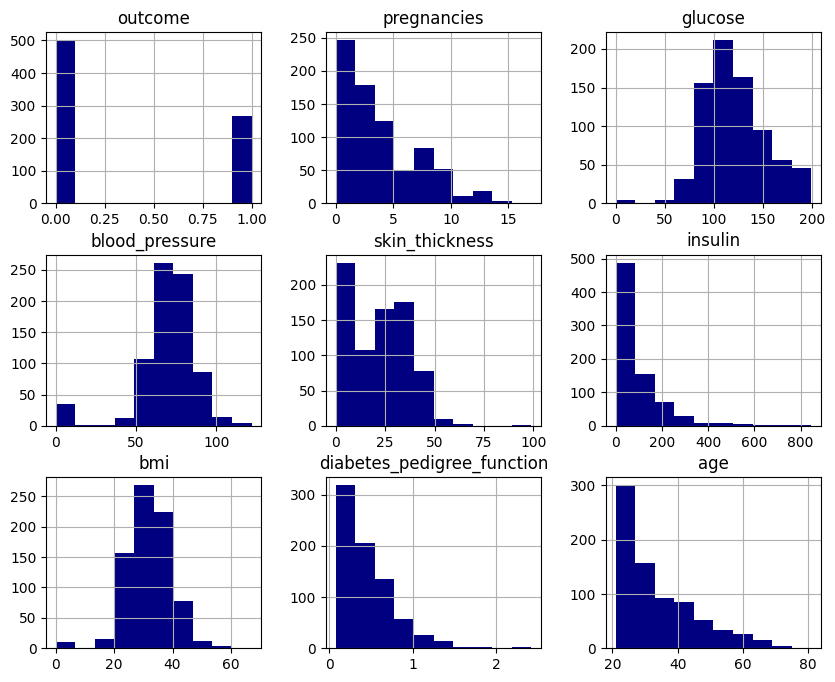

In [177]:
# Plots histogram of each column
df.hist(figsize=(10, 8), color='navy')
plt.show()

In [178]:
# Counts zeroes in each column
(df == 0).sum()

outcome                       500
pregnancies                   111
glucose                         5
blood_pressure                 35
skin_thickness                227
insulin                       374
bmi                            11
diabetes_pedigree_function      0
age                             0
dtype: int64

In [179]:
# Replaces zeroes with NaN
df[[
        'glucose',
        'blood_pressure',
        'skin_thickness',
        'insulin',
        'bmi'
    ]] = df[[
            'glucose',
            'blood_pressure',
            'skin_thickness',
            'insulin',
            'bmi'
             ]].replace(0, np.nan)
    
df.isnull().sum() # Counts NaNs

outcome                         0
pregnancies                     0
glucose                         5
blood_pressure                 35
skin_thickness                227
insulin                       374
bmi                            11
diabetes_pedigree_function      0
age                             0
dtype: int64

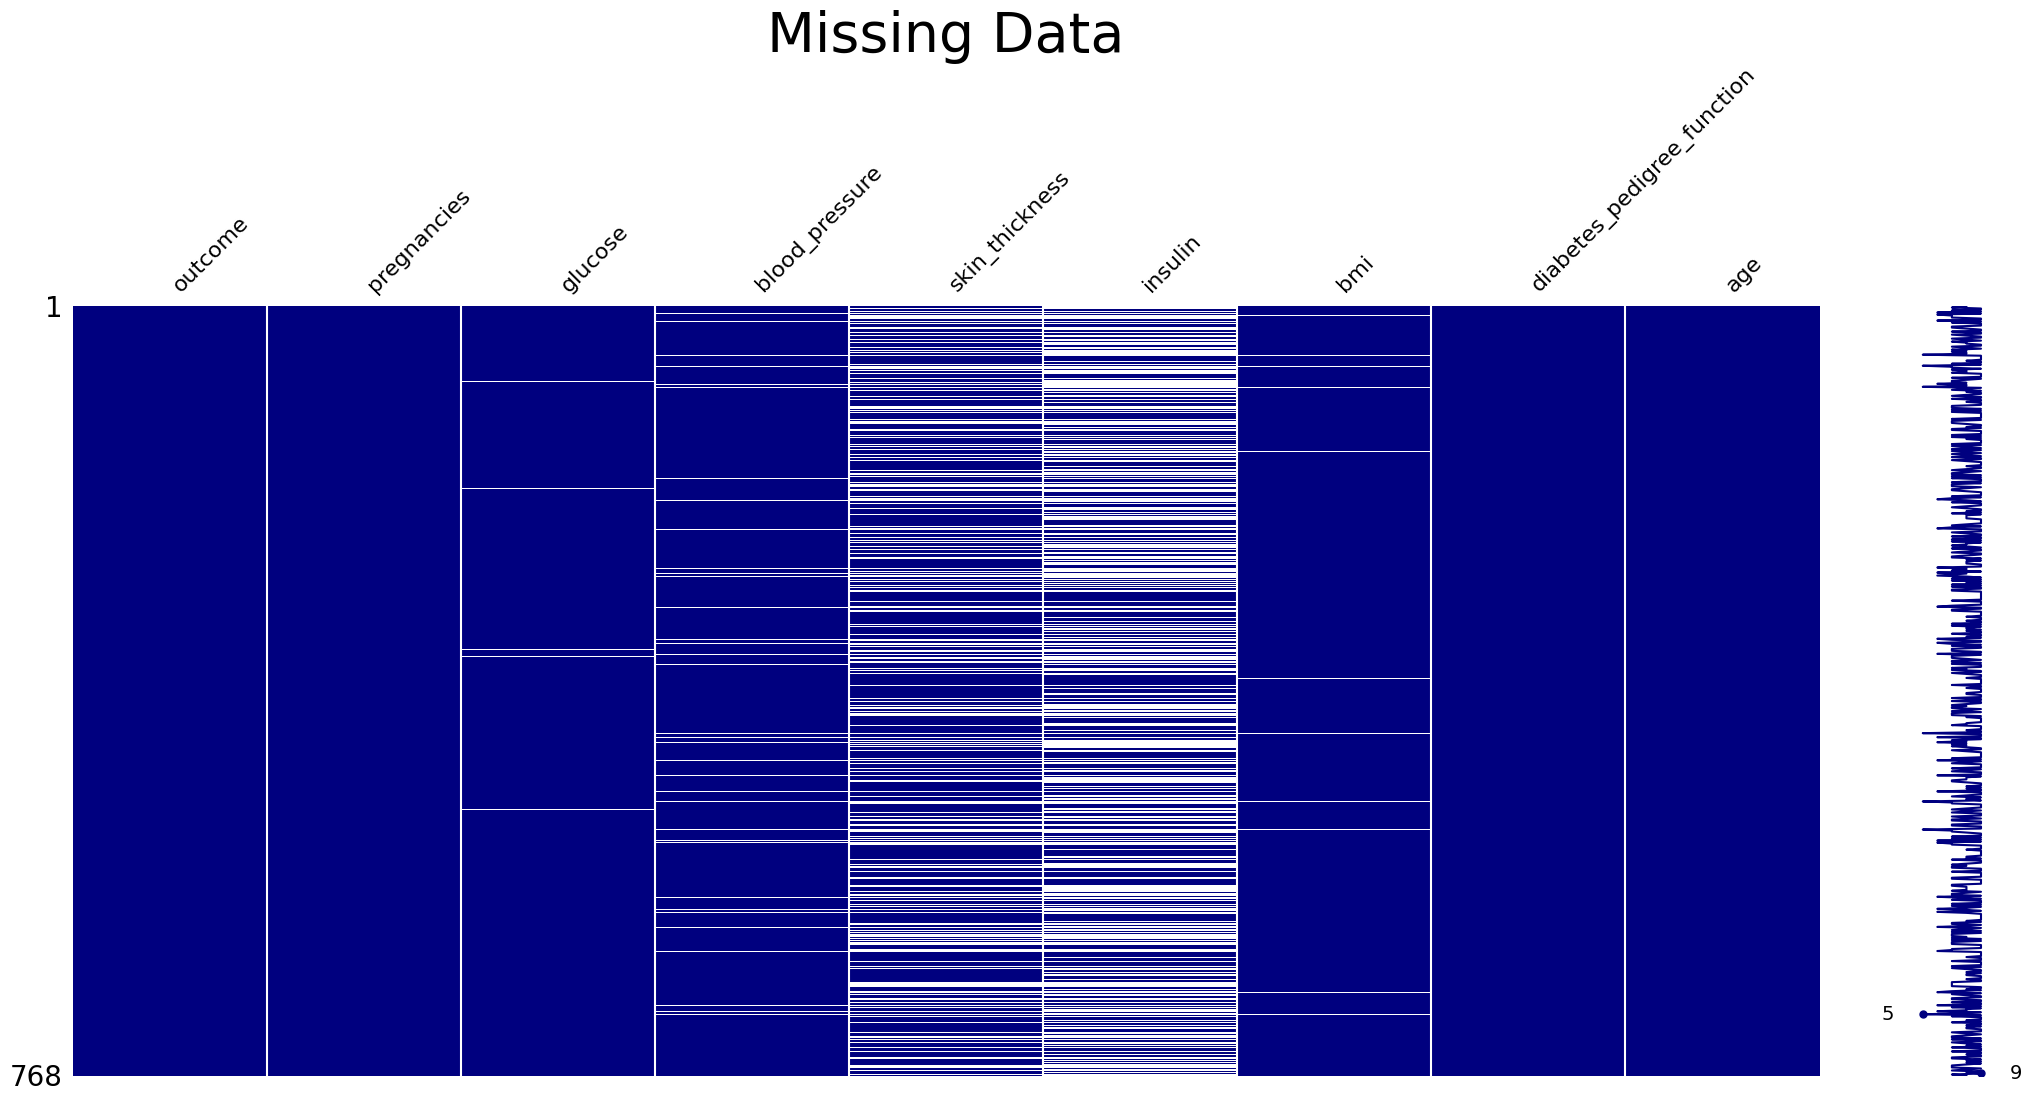

In [180]:
# Visualizes missing data
msno.matrix(df, color=(0.0, 0.0, 0.5))
plt.title('Missing Data', fontsize=40)
plt.show()

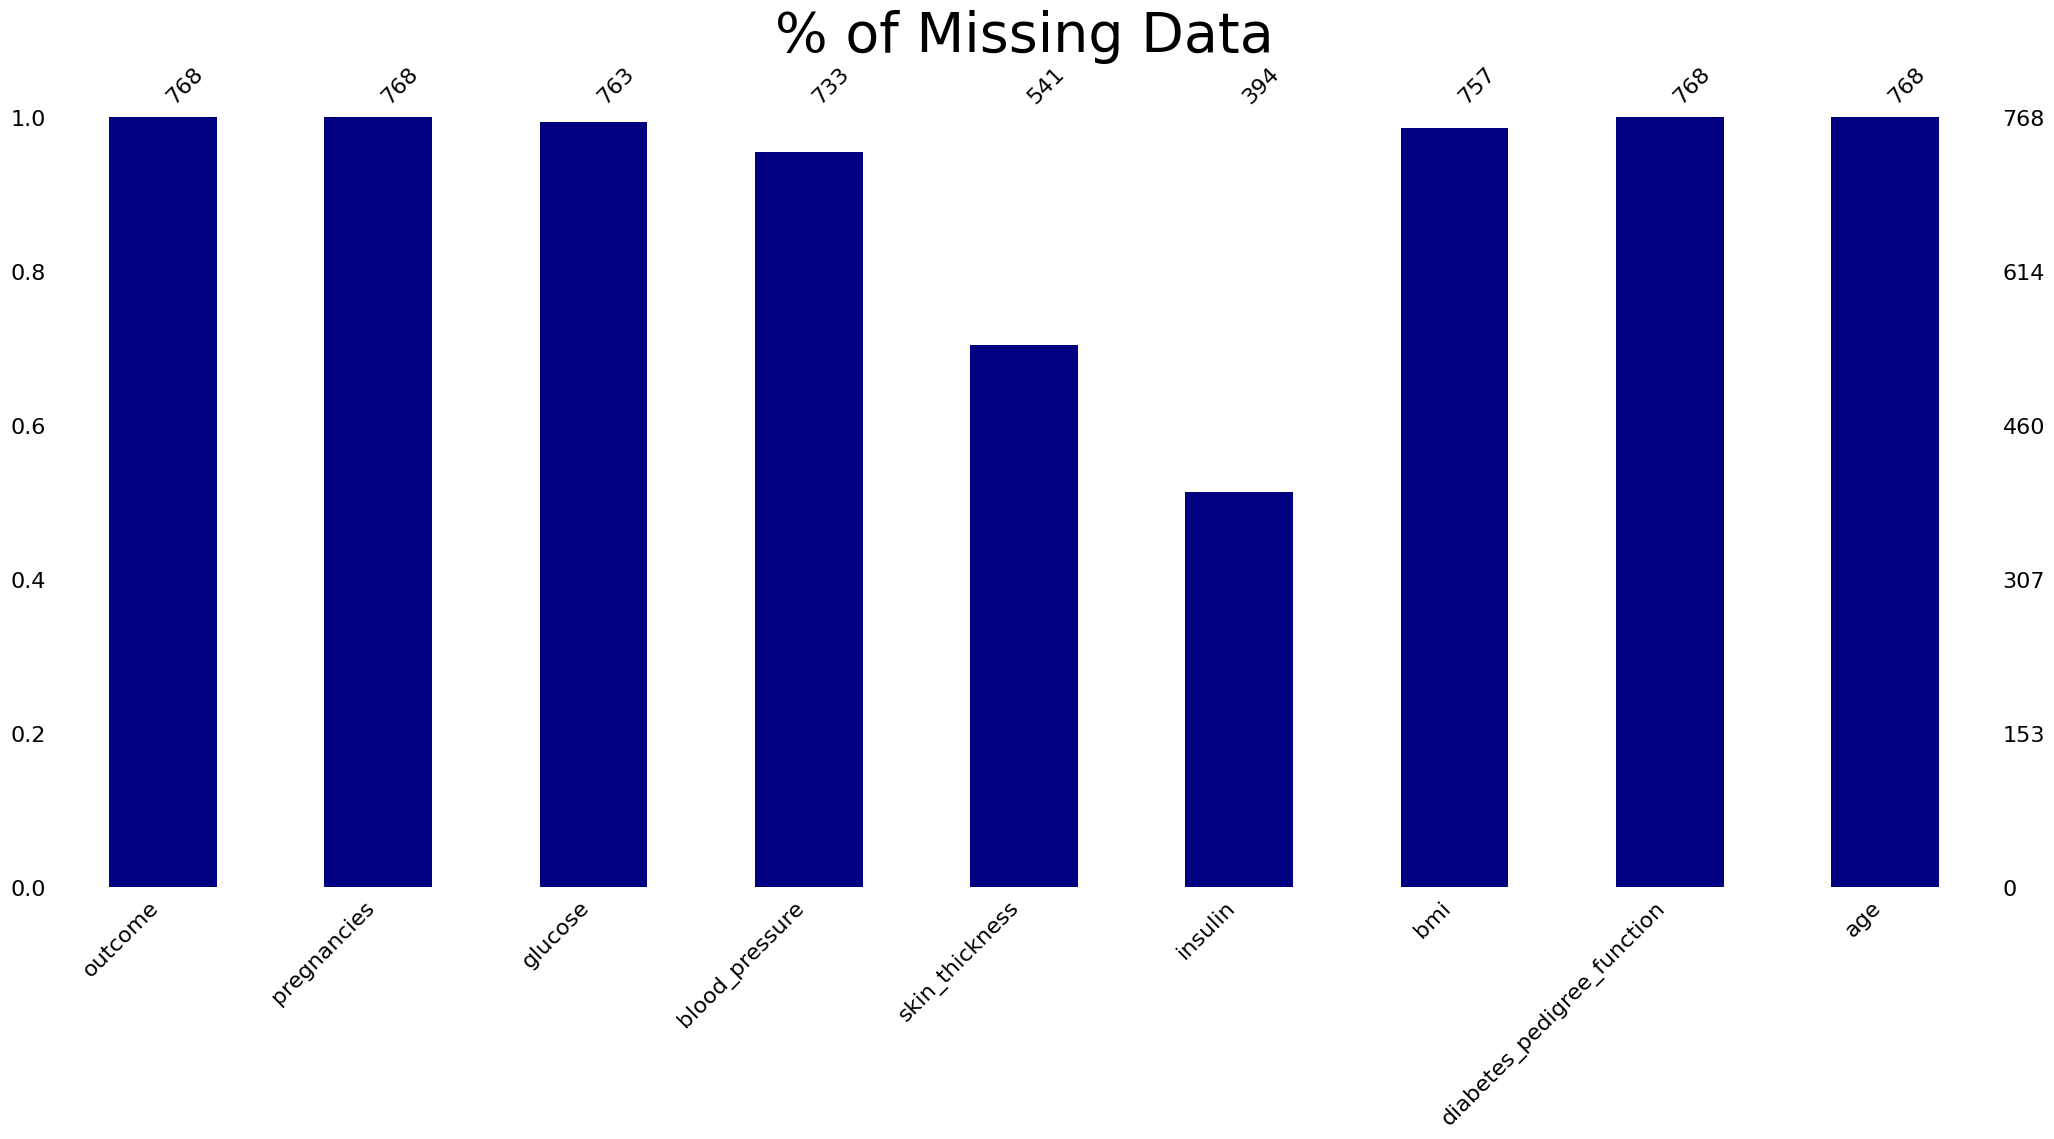

In [181]:
# Visualizes missing data with %
msno.bar(df, color='navy')
plt.title('% of Missing Data', fontsize=40)
plt.show()

## Imputation

In [182]:
# Sets up kernel
kernel = mf.ImputationKernel(
    data=df,
    random_state=1000
    )
# Performs 2 rounds of MICE with 6 iterations each
kernel.mice(2, n=6, save_all_iterations=True)

In [183]:
# Extracts the first imputed dataset after MICE
complete = kernel.complete_data(dataset=0)
# Checks for any remaining missing values
print(complete.isnull().sum())

outcome                       0
pregnancies                   0
glucose                       0
blood_pressure                0
skin_thickness                0
insulin                       0
bmi                           0
diabetes_pedigree_function    0
age                           0
dtype: int64


## Balancing the dataset

In [184]:
# Extracts metadata
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=complete)
metadata

{
    "columns": {
        "outcome": {
            "sdtype": "categorical"
        },
        "pregnancies": {
            "sdtype": "numerical"
        },
        "glucose": {
            "sdtype": "numerical"
        },
        "blood_pressure": {
            "sdtype": "numerical"
        },
        "skin_thickness": {
            "sdtype": "numerical"
        },
        "insulin": {
            "sdtype": "numerical"
        },
        "bmi": {
            "sdtype": "numerical"
        },
        "diabetes_pedigree_function": {
            "sdtype": "numerical"
        },
        "age": {
            "sdtype": "numerical"
        }
    },
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1"
}

In [185]:
# Sets up synthetic data model
ctgan = CTGANSynthesizer(
    metadata=metadata,
    enforce_min_max_values=True,
    enforce_rounding=True,
    epochs=200,
    batch_size=100
    )

c:\Users\furba\OneDrive\Pulpit\stuff\Projekty\DIABETIES_PREDICTION\venv\Lib\site-packages\sdv\single_table\base.py:129: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


In [186]:
# Trains the model
ctgan.fit(complete)
synthetic_ctgan = ctgan.sample(len(complete))

In [187]:
# Evaluates quality of synthetic data
evaluate_quality(
    real_data=complete,
    synthetic_data=synthetic_ctgan,
    metadata=metadata
    )

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 9/9 [00:00<00:00, 299.94it/s]|
Column Shapes Score: 77.56%

(2/2) Evaluating Column Pair Trends: |██████████| 36/36 [00:00<00:00, 88.45it/s]|
Column Pair Trends Score: 86.52%

Overall Score (Average): 82.04%



In [188]:
# Counts binary variable
synthetic_ctgan['outcome'].value_counts()

outcome
0    394
1    374
Name: count, dtype: int64

In [189]:
# Calculates descriptive statistics
synthetic_ctgan.describe().round().T

,count,mean,std,min,25%,50%,75%,max
outcome,768.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
pregnancies,768.0,8.0,5.0,0.0,3.0,8.0,13.0,17.0
glucose,768.0,127.0,47.0,44.0,87.0,126.0,167.0,199.0
blood_pressure,768.0,82.0,15.0,32.0,73.0,84.0,93.0,122.0
skin_thickness,768.0,33.0,10.0,7.0,26.0,32.0,38.0,64.0
insulin,768.0,140.0,142.0,14.0,37.0,99.0,191.0,846.0
bmi,768.0,28.0,9.0,18.0,21.0,27.0,34.0,67.0
diabetes_pedigree_function,768.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0
age,768.0,36.0,12.0,21.0,25.0,35.0,44.0,81.0


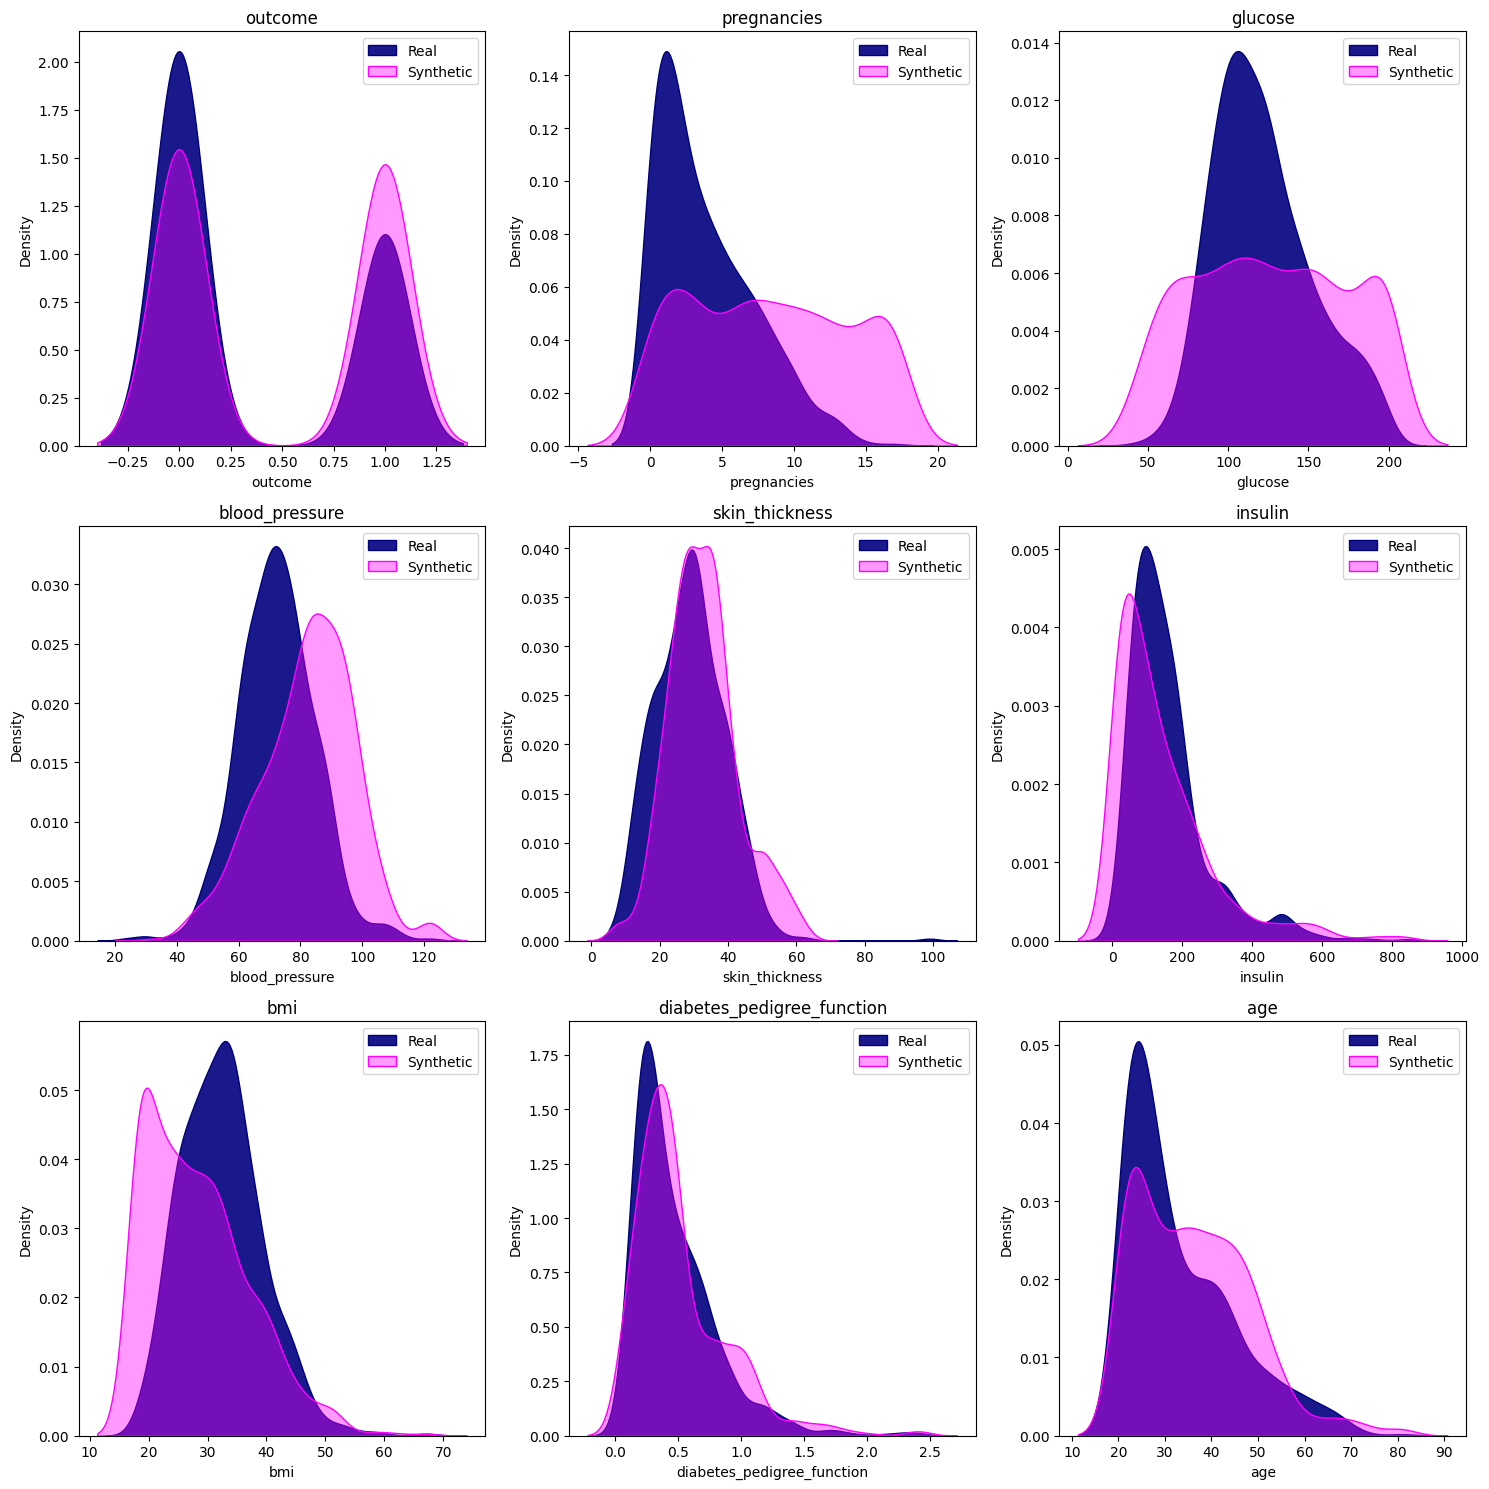

In [190]:
# Visualizes and compares feature distribution between real and synthetic data
columns = complete.columns
n_cols = 3
n_rows = (len(columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(columns):
    sns.kdeplot(complete[col], label='Real', fill=True, alpha=0.9, ax=axes[i], color='navy')
    sns.kdeplot(synthetic_ctgan[col], label='Synthetic', fill=True, alpha=0.4, ax=axes[i], color='magenta')
    axes[i].set_title(col)
    axes[i].legend()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Correlation

In [191]:
# Computes correlation for synthetic data
corr_matrix = synthetic_ctgan.corr()

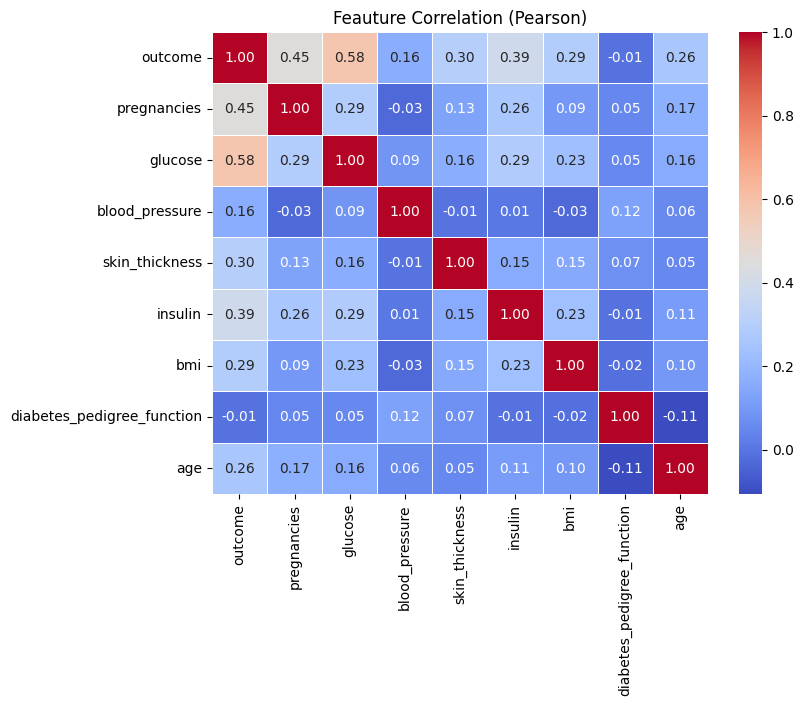

In [192]:
# Visualizes feature relationships (Pearson)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix,
            annot=True,
            cmap='coolwarm',
            fmt=".2f",
            linewidths=0.5)
plt.title('Feauture Correlation (Pearson)')
plt.show()

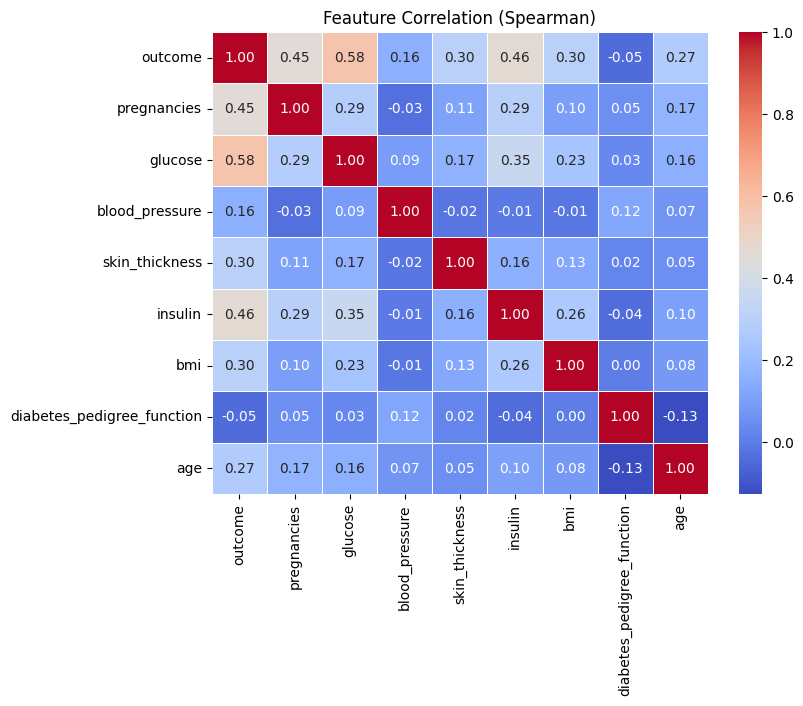

In [193]:
# Visualizes feature relationships (Spearman)
plt.figure(figsize=(8, 6))
sns.heatmap(synthetic_ctgan.corr(method='spearman'),
            annot=True,
            cmap='coolwarm',
            fmt=".2f",
            linewidths=0.5)
plt.title('Feauture Correlation (Spearman)')
plt.show()

## Division into training and test sets

In [194]:
# Creates set with features and target variable
X = synthetic_ctgan.drop(columns='outcome')
Y = synthetic_ctgan['outcome']

In [195]:
# Splits data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    Y,
                                                    test_size=0.3,
                                                    random_state=123,
                                                    stratify=Y)

## Models

### kNN

In [196]:
# Scales features
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

In [197]:
# Initializes model
knn = KNeighborsClassifier(n_neighbors=7)

In [198]:
# Configures grid search and sets cross validation
grid_search = {'cv': 5, 'scoring': 'accuracy'}

In [199]:
# Tunes hyperparameter
knn_hyper = GridSearchCV(
    knn,
    param_grid={'n_neighbors': [3, 5, 7]}, # number of tested neighbors
    **grid_search # Injects cv and scoring parameters
    )
knn_hyper.fit(X_train_std, Y_train) # Trains and evaluates model

,estimator,KNeighborsCla...n_neighbors=7)
,param_grid,"{'n_neighbors': [3, 5, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,7


In [200]:
# Outputs best hyperparameters and score
print(knn_hyper.best_params_)
print(knn_hyper.best_score_)

{'n_neighbors': 7}
0.843509865005192


In [201]:
# Evaluates model on test set
knn_hyper.score(X_test_std, Y_test)

0.8138528138528138

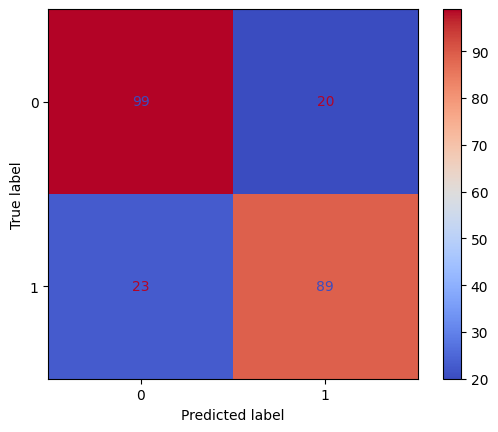

In [202]:
# Visualizes classification performance
ConfusionMatrixDisplay.from_predictions(Y_test, knn_hyper.predict(X_test_std), cmap='coolwarm')
plt.show()

In [203]:
# Creates classification report
print(classification_report(Y_test, knn_hyper.predict(X_test_std)))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       119
           1       0.82      0.79      0.81       112

    accuracy                           0.81       231
   macro avg       0.81      0.81      0.81       231
weighted avg       0.81      0.81      0.81       231



In [204]:
# Calculates ROC/AUC score on training data
knn_Y_pred_train = knn_hyper.predict_proba(X_train_std)[:, 1]
knn_roc_auc_train = roc_auc_score(Y_train, knn_Y_pred_train)
knn_roc_auc_train

0.9465163081193616

In [205]:
# Calculates ROC/AUC score on test data
knn_Y_pred_test = knn_hyper.predict_proba(X_test_std)[:, 1]
knn_roc_auc_test = roc_auc_score(Y_test, knn_Y_pred_test)
knn_roc_auc_test

0.8710984393757503

### SVM

In [206]:
svm = SVC(kernel='rbf', probability=True) # Initializes SVM model with RBF kernel
params = {'C': [0.1, 1], 'gamma': [0.0001, 0.001, 0.01]} # Sets hyperparameters for SVM
svm_hyper = GridSearchCV(svm, params, **grid_search) # Configures grid search
svm_hyper.fit(X_train_std, Y_train) # Trains SVM model with hyperparameter tuning

,estimator,SVC(probability=True)
,param_grid,"{'C': [0.1, 1], 'gamma': [0.0001, 0.001, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,1


In [207]:
print(svm_hyper.best_params_) # Outputs best hyperparameters
print(svm_hyper.best_score_) # Outputs best accuracy score

{'C': 1, 'gamma': 0.01}
0.8752163378331602


In [208]:
svm_hyper.score(X_test_std, Y_test) # Evaluates model on test set

0.8441558441558441

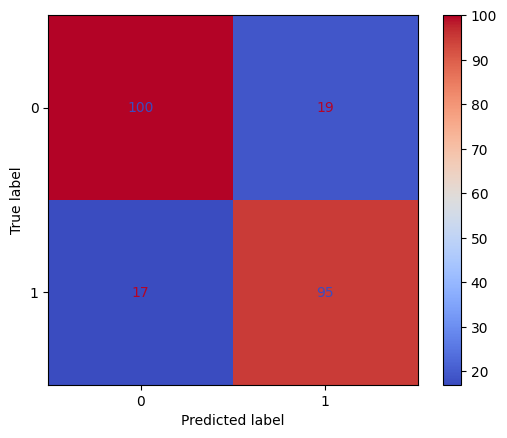

In [209]:
# Visualizes classification performance
ConfusionMatrixDisplay.from_predictions(Y_test, svm_hyper.predict(X_test_std), cmap='coolwarm')
plt.show()

In [210]:
# Creates classification report
print(classification_report(Y_test, svm_hyper.predict(X_test_std)))

              precision    recall  f1-score   support

           0       0.85      0.84      0.85       119
           1       0.83      0.85      0.84       112

    accuracy                           0.84       231
   macro avg       0.84      0.84      0.84       231
weighted avg       0.84      0.84      0.84       231



In [211]:
svm_Y_pred_train = svm_hyper.predict_proba(X_train_std)[:, 1]
svm_roc_auc_train = roc_auc_score(Y_train, svm_Y_pred_train)
svm_roc_auc_train

0.9409784871616933

In [212]:
svm_Y_pred_test = svm_hyper.predict_proba(X_test_std)[:, 1] # Predicts probabilities for test set
svm_roc_auc_test = roc_auc_score(Y_test, svm_Y_pred_test) # Evaluates model on test set
svm_roc_auc_test

0.9181422569027611

### XGBoost

In [213]:
# Creates an XGBoost model for classification
xgbst = xgb.XGBClassifier(objective='binary:logistic')

In [214]:
# Sets hyperparameters for XGBoost model
params = {
    'learning_rate': [0.01, 0.1, 0.5], # Controls the contribution of each tree (smaller = slower learning)
    'n_estimators': [100], # Number of trees
    'max_depth': [4], # Maximum depth of each tree
    'subsample': [0.25, 0.5, 0.75], # Fraction of samples used for training each tree
    'gamma': [0.0001, 0.001, 0.01] # Minimum loss reduction required to make a further partition
}

In [215]:
# Configures grid search for hyperparameter tuning
xgb_hyper = GridSearchCV(estimator=xgbst, param_grid=params, **grid_search)

In [216]:
# Fits the model to the training data
xgb_hyper.fit(X_train, Y_train)

,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'gamma': [0.0001, 0.001, ...], 'learning_rate': [0.01, 0.1, ...], 'max_depth': [4], 'n_estimators': [100], ...}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [217]:
print(xgb_hyper.best_params_) # Outputs best hyperparameters
print(xgb_hyper.best_score_) # Outputs best accuracy score

{'gamma': 0.0001, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.25}
0.8640706126687435


In [218]:
xgb_hyper.score(X_test, Y_test) # Evaluates model on test set

0.8268398268398268

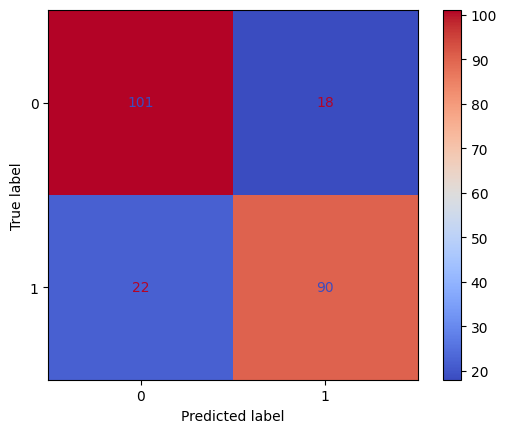

In [219]:
# Visualizes classification performance
ConfusionMatrixDisplay.from_predictions(Y_test, xgb_hyper.predict(X_test), cmap='coolwarm')
plt.show()

In [220]:
# Creates classification report
print(classification_report(Y_test, xgb_hyper.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.85      0.83       119
           1       0.83      0.80      0.82       112

    accuracy                           0.83       231
   macro avg       0.83      0.83      0.83       231
weighted avg       0.83      0.83      0.83       231



In [221]:
xgb_Y_pred_train = xgb_hyper.predict_proba(X_train)[:, 1] # Predicts probabilities for training set
xgb_roc_auc_train = roc_auc_score(Y_train, xgb_Y_pred_train) # Evaluates model on training set
xgb_roc_auc_train

0.9564052741151978

In [222]:
xgb_Y_pred_test = xgb_hyper.predict_proba(X_test)[:, 1] # Predicts probabilities for test set
xgb_roc_auc_test = roc_auc_score(Y_test, xgb_Y_pred_test) # Evaluates model on test set
xgb_roc_auc_test

0.8987845138055222

## Evaluation

### ROC curve

In [223]:
# Calculates ROC curves for each model
knn_fpr, knn_tpr, _ = roc_curve(Y_test, knn_Y_pred_test)
svm_fpr, svm_tpr, _ = roc_curve(Y_test, svm_Y_pred_test)
xgb_fpr, xgb_tpr, _ = roc_curve(Y_test, xgb_Y_pred_test)

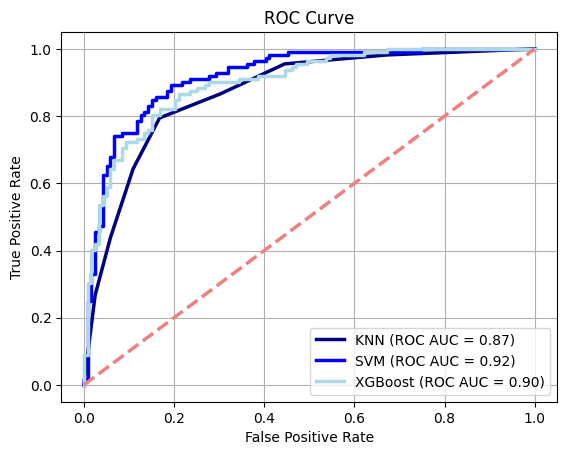

In [224]:
# Plots ROC curves for each model
plt.plot(knn_fpr,
         knn_tpr,
         linestyle='-',
         linewidth=2.5,
         color='navy',
         label='KNN (ROC AUC = {:.2f})'.format(knn_roc_auc_test))
plt.plot(svm_fpr,
         svm_tpr,
         linestyle='-',
         linewidth=2.5,
         color='blue',
         label='SVM (ROC AUC = {:.2f})'.format(svm_roc_auc_test))
plt.plot(xgb_fpr,
         xgb_tpr,
         linestyle='-',
         linewidth=2.5,
         color='lightblue',
         label='XGBoost (ROC AUC = {:.2f})'.format(xgb_roc_auc_test))

plt.plot([0, 1], [0, 1], linestyle='--', linewidth=2.5, color='lightcoral')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.grid(True)
plt.show()

The results shown in the chart above present a comparison of three methods: kNN, SVM, and XGBoost. The SVM model achieves the highest score of 0.92 (AUC), indicating its superior performance compared to the others. Its ratio of true positive results to all positive cases, relative to the ratio of false positive results to all negative cases, best reflects the actual data distribution.

## Interpretability of chosen model

In [225]:
# Saves the best model for future use
best_model = deepcopy(svm_hyper)

Using 231 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 231/231 [05:01<00:00,  1.30s/it]


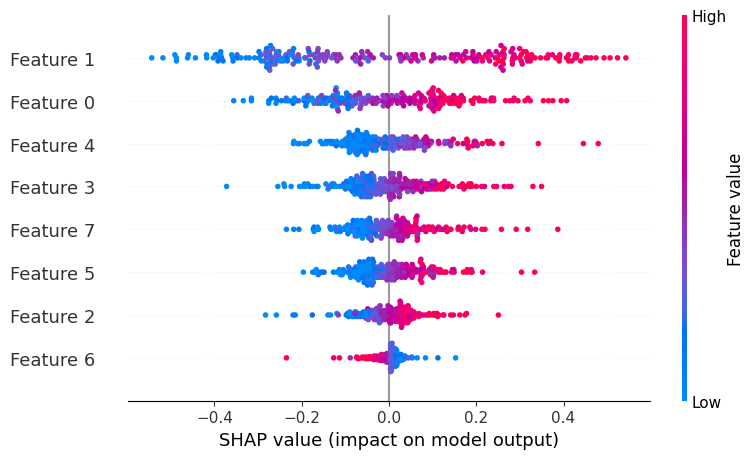

                     col_name  feature_importance_vals
1                     glucose                 0.244164
0                 pregnancies                 0.127069
4                     insulin                 0.082144
3              skin_thickness                 0.079364
7                         age                 0.067866
5                         bmi                 0.063137
2              blood_pressure                 0.047682
6  diabetes_pedigree_function                 0.021597


In [226]:
explainer = shap.KernelExplainer(best_model.predict, X_test_std) # Uses KernelExplainer for model explanation
    
shap_values = explainer.shap_values(X_test_std) # Computes SHAP values for test data

shap.initjs()
shap.summary_plot(shap_values, X_test_std) # Visual summary of feature impact

vals = abs(shap_values).mean(0) # Computes mean absolute SHAP values per feature
feature_names = cols[1:]  # Exclude target column ('outcome') from feature names

feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                          columns=['col_name', 'feature_importance_vals']) # Creates DataFrame of importances

feature_importance.sort_values(by=['feature_importance_vals'],
                                       ascending=False, inplace=True) # Sorts by importance

print(feature_importance) # Displays sorted feature importance

As expected, the most important predictor turned out to be blood glucose level. By definition, diabetes is a chronic condition caused by impaired insulin secretion. An insufficient amount of insulin in the body leads to problems with glucose uptake by cells, resulting in increased blood glucose levels (hyperglycemia) and the excretion of glucose in urine. (source: https://www.medonet.pl/magazyny/wszystko-o-cukrzycy,cukrzyca---rodzaje--przyczyny--objawy--leczenie,artykul,1580080.html?srcc=undefined&utm_v=2)

Accordingly, the second most important predictor is likely insulin. On the other hand, the least significant variables turned out to be age and the number of pregnancies.

In [227]:
shap.force_plot(explainer.expected_value, shap_values, X_test_std) # Force plot for individual prediction explanation

In the force plot visualization, it can be observed that high glucose levels indicate the presence of diabetes, while low glucose levels suggest its absence.

In [228]:
# Converts scaled test data back to DataFrame for visualization
X_test_std = pd.DataFrame(X_test_std, columns = X_test.columns)

In [229]:
shap.force_plot(explainer.expected_value, shap_values[42,:], X_test_std.iloc[42, :]) # Force plot for specific instance

In a specific case (index 42), the final outcome is the absence of diabetes. The most important predictor is glucose (the longest segment), with a standardized value of -1.4, along with a low BMI. On the other hand, an above-normal insulin level was the only factor that leaned toward indicating the presence of diabetes.

## Interpretation of final results

The project aimed to predict the occurrence of diabetes using various classification methods. After conducting the analysis and comparing different models using the ROC curve, the Support Vector Machine (SVM) was selected as the most effective classification method.

The ROC curve analysis showed that the SVM model had the best ability to distinguish between individuals with diabetes and healthy individuals, confirming its effectiveness for this particular application.

During the interpretation of the model’s behavior using the SHAP library, it was discovered that blood glucose level was the most important predictor of diabetes onset. Insulin level also had a significant impact, which aligns with medical knowledge about the mechanisms of diabetes development.

In conclusion, the SVM model proved to be the best choice for predicting diabetes occurrence in the analyzed dataset. The most important predictors were blood glucose level and insulin, emphasizing their key role in the diagnosis and monitoring of diabetes.